In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from zhon.hanzi import punctuation # 中文标点
import jieba
import re

In [2]:
# st标签
path_label='F:\zzqaq\data\\label_is_ST_2021.csv'
label = pd.read_csv(path_label,encoding="gbk",converters={'code':str, 'year':str})
# 去重
label.drop_duplicates(subset=['code'],keep='first',inplace=True) 

# 数据
text_all_18_20_path ='F:\\zzqaq\\data\\text_all_18_20.csv'
text_all_18_20 = pd.read_csv(text_all_18_20_path,encoding="gb18030",converters={'code':str,'year':str})
text_all_18_20.dropna(subset=['year', 'text'], inplace=True) # 去空值（没提取出来）
text_all_18_20.drop_duplicates(subset=['code','year'],keep='first',inplace=True) 

————————————————————————————————
### 查看每个code、year个数及分布  
不超过3个，多了看原因。去除空值（没提取出），去重（分板块去重过，但合并后要重新去重）

In [3]:
text_all_18_20.nunique()

code    3635
year       4
text    8277
dtype: int64

In [4]:
# df文件text_all_18_20去除year列值不等于2018、2019、2020的行
# text_all_18_20.dropna(subset=['year'], inplace=True) # 去空值但是没去掉
text_all_18_20 = text_all_18_20[text_all_18_20['year'].isin(['2018', '2019', '2020'])]
text_all_18_20.nunique()

code    3635
year       3
text    8276
dtype: int64

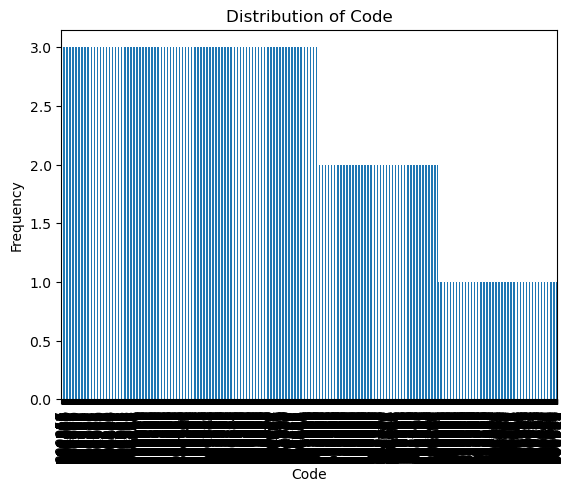

In [5]:
# 每种 code 出现的次数
counts = text_all_18_20['code'].value_counts()

# 绘制柱形图
counts.plot(kind='bar')
plt.xlabel('Code')
plt.ylabel('Frequency')
plt.title('Distribution of Code')
plt.show()

# 没有数量超过3的代码

每个code、year个数及分布  
————————————————————————————————

————————————————————————————————
### board提取，看分布

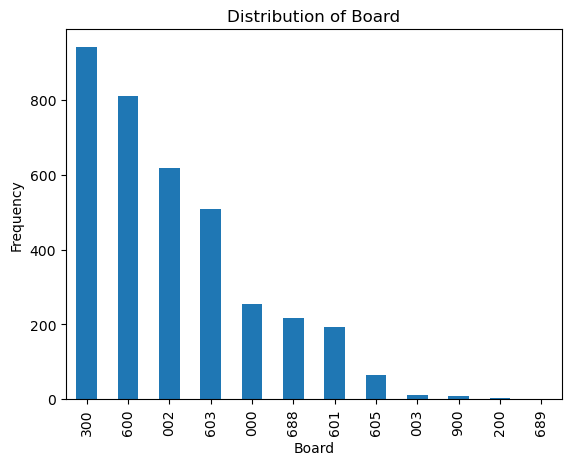

In [7]:
# 三位数分布
text_all_18_20['board'] = text_all_18_20['code'].map(lambda x:x[:3])
text_all_18_20_deduplicated = text_all_18_20.drop_duplicates(subset=['code'],keep='first')
counts = text_all_18_20_deduplicated['board'].value_counts()
# 绘制柱形图
counts.plot(kind='bar')
plt.xlabel('Board')
plt.ylabel('Frequency')
plt.title('Distribution of Board')
plt.show()

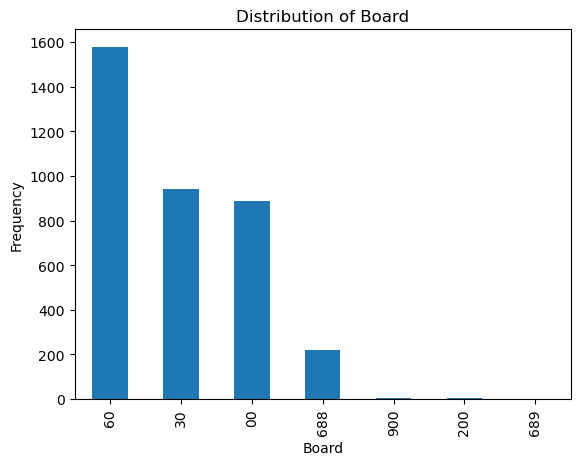

In [8]:
# 细化板块分布
# 00深交所主板：000、001；中小板：002、003（和主板合并；
text_all_18_20.loc[text_all_18_20['code'].str.startswith('00'), 'board'] = '00'
# 60上交所主板：600、601、603、605；
text_all_18_20.loc[text_all_18_20['code'].str.startswith('60'), 'board'] = '60'
# 30创业板：300、301；
text_all_18_20.loc[text_all_18_20['code'].str.startswith('30'), 'board'] = '30'
# 84股票代码8或4打头：新三板/北交
text_all_18_20.loc[(text_all_18_20['code'].str.startswith('8')) 
                   | (text_all_18_20['code'].str.startswith('4')), 'board'] = '84'
# 科创板：688；上证B股：900；深圳B股：200、201；

text_all_18_20_deduplicated = text_all_18_20.drop_duplicates(subset=['code'],keep='first')
# text_all_18_20_deduplicated :3635 rows

counts = text_all_18_20_deduplicated['board'].value_counts()
# print(counts)
# 绘制柱形图
counts.plot(kind='bar')
plt.xlabel('Board')
plt.ylabel('Frequency')
plt.title('Distribution of Board')
plt.show()

沪主板、创业板、深主板、科创板较多

 board提取，看分布  
————————————————————————————————


————————————————————————————————
### text处理  - 处理后已保存  
截取节管理层讨论与分析之后、公司治理之前的内容   
截取后字数不能过少

In [9]:
text_all_18_20.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8276 entries, 0 to 10814
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   code    8276 non-null   object
 1   year    8276 non-null   object
 2   text    8276 non-null   object
 3   board   8276 non-null   object
dtypes: object(4)
memory usage: 323.3+ KB


In [10]:
# 有’讨论与分析‘
text_all_18_20_tl = text_all_18_20[text_all_18_20['text'].str.contains('讨论与分析')]
text_all_18_20_tl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7794 entries, 0 to 10814
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   code    7794 non-null   object
 1   year    7794 non-null   object
 2   text    7794 non-null   object
 3   board   7794 non-null   object
dtypes: object(4)
memory usage: 304.5+ KB


In [11]:
text_all_18_20_tl.head(3)

,code,year,text,board
0,000004,2018,深圳中国农大科技股份有限公司年年度报告全文第四节经营情况讨论与分析一概述年度，公司实现主营业...,00
1,000004,2020,深圳国华网安科技股份有限公司年年度报告全文第四节经营情况讨论与分析一概述年是公司业务转型后的...,00
2,000005,2018,深圳世纪星源股份有限公司年年度报告全文第四节经营情况讨论与分析一概述在本报告期内，本司主营业...,00


In [12]:
# text列截取’讨论与分析‘之后的内容并替换原text，同时‘讨论与分析’保留；
new_text = [s[s.find('讨论与分析'):] for s in text_all_18_20_tl['text']]
text_all_18_20_tl['text'] = new_text

# 截取’节公司治理‘且在'节重要事项'之前
new_text_2 = [s[:s.find('节公司治理')] if '节公司治理' in s
              else s 
              for s in text_all_18_20_tl['text']]
text_all_18_20_tl['text'] = new_text_2

new_text_3 = [s[:s.find('节重要事项')] if '节重要事项' in s
              else s 
              for s in text_all_18_20_tl['text']]
text_all_18_20_tl['text'] = new_text_3

C:\Users\asus\AppData\Local\Temp\ipykernel_15940\2568177509.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_all_18_20_tl['text'] = new_text
C:\Users\asus\AppData\Local\Temp\ipykernel_15940\2568177509.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_all_18_20_tl['text'] = new_text_2
C:\Users\asus\AppData\Local\Temp\ipykernel_15940\2568177509.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

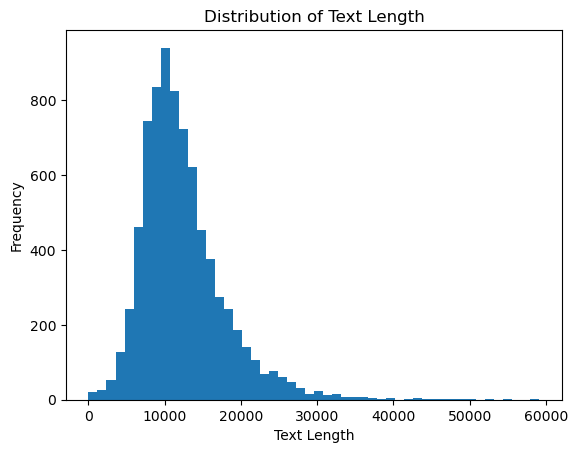

In [13]:
# text列的文本字符数分布情况 画图
counts = text_all_18_20_tl['text'].str.len()
plt.hist(counts, bins=50)
plt.title('Distribution of Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

In [14]:
# 查看字数过少并过滤掉。字数多一般不是问题。
df_filtered = text_all_18_20_tl[(text_all_18_20_tl['text'].str.len() >= 700) ]
#                  & (text_all_18_20_tl['text'].str.len() <= 40000)]
df_filtered_min = text_all_18_20_tl[(text_all_18_20_tl['text'].str.len() <= 700) ]
df_filtered_min

,code,year,text,board
299,000752,2020,讨论与分析一概述公司自年月起，陆续暴发了多起诉讼仲裁详见本报告第五,00
1016,002473,2020,讨论与分析一概述一基本经营情况受宏观经济影响，公司遭遇了前所未有的困难。报告期内，公司依然面...,00
1811,300051,2019,讨论与分析第五,30
1833,300056,2018,讨论与分析第五,30
2649,300263,2018,讨论与分析之一概述中子公司相关内容隆华科技集团洛阳股份有限公司年年度报告全文第六节股份变动及...,30
2691,300272,2018,讨论与分析中一概述五重大事项以及七主要控股参股公司分析。报告期内，公司转让其原子公司浙江润鑫...,30
5585,600233,2018,讨论与分析中公司关于公司未来发展的讨论与分析部分予以了详细描述，敬请投资者注意风险。十其他□...,60
5586,600233,2019,讨论与分析中公司关于公司未来发展的讨论与分析部分予以了详细描述，敬请投资者注意风险。十其他□...,60
5900,600332,2019,讨论与分析中三未来发展的讨论与分析之三可能面对的挑战与风险一节。十本年度报告分别以中英文两种...,60
6774,600626,2020,讨论与分析一经营情况讨论与分析年是十三五的收官之年，过去五年，公司通过收购兼并及内生性拓展，...,60


In [197]:
# 保存
df_filtered['board'] = df_filtered['board'].astype(str)
df_filtered.to_csv('F:\\zzqaq\\data\\data_clean_2018_2020.csv',encoding="gb18030",index = False)

C:\Users\asus\AppData\Local\Temp\ipykernel_20772\786670838.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['board'] = df_filtered['board'].astype(str)


In [16]:
# 读取
text_1820_path ='F:\\zzqaq\\data\\data_clean_2018_2020.csv'
text_1820 = pd.read_csv(text_1820_path,encoding="gb18030",converters={'code':str,'year':str,'board':str})
text_1820["board"] = [str(i).replace("\t","") for i in text_1820["board"]]